In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load data
data = pd.read_csv('/Users/ngtnkiet/Downloads/hello_ds/merged_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
data.set_index('date', inplace=True)

# Fill missing values
data.fillna(0, inplace=True)

In [3]:
# Separate features and target
X = data.drop('price_change', axis=1)
y = data['price_change']

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, window_size=20):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

In [4]:
# Train/val/test split
train_size = int(0.7 * len(X_seq))
val_size = int(0.15 * len(X_seq))

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [8]:
def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_layers=2):
    inputs = Input(shape=input_shape)
    # Project input features to head_size
    x = Dense(head_size)(inputs)
    for _ in range(num_layers):
        x1 = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
        x1 = LayerNormalization(epsilon=1e-6)(x + x1)
        x2 = tf.keras.layers.Dense(ff_dim, activation='relu')(x1)
        x2 = tf.keras.layers.Dense(head_size)(x2)
        x = LayerNormalization(epsilon=1e-6)(x1 + x2)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


In [9]:
# Train models
lstm_model = build_lstm_model(X_train.shape[1:])
history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
                              validation_data=(X_val, y_val),
                              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                              verbose=1)

transformer_model = build_transformer_model(X_train.shape[1:])
history_transformer = transformer_model.fit(X_train, y_train, epochs=100, batch_size=32,
                                            validation_data=(X_val, y_val),
                                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                                            verbose=1)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3421 - val_loss: 0.0892
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0828 - val_loss: 0.0418
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0618 - val_loss: 0.0218
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0444 - val_loss: 0.0125
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0264 - val_loss: 0.0129
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0276 - val_loss: 0.0120
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0213 - val_loss: 0.0120
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0174 - val_loss: 0.0122
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0148 - val_loss: 0.0119
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0148 - val_loss: 0.0117
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0153 - val_loss: 0.0117
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0114 - val_lo

In [10]:
# Predictions
def inverse_transform_and_plot(model, X_train, y_train, X_test, y_test, name):
    # Train predictions
    train_preds = model.predict(X_train)
    train_preds_inv = target_scaler.inverse_transform(train_preds)
    y_train_inv = target_scaler.inverse_transform(y_train)

    # Test predictions
    test_preds = model.predict(X_test)
    test_preds_inv = target_scaler.inverse_transform(test_preds)
    y_test_inv = target_scaler.inverse_transform(y_test)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_preds_inv))
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))
    train_mae = mean_absolute_error(y_train_inv, train_preds_inv)
    test_mae = mean_absolute_error(y_test_inv, test_preds_inv)

    print(f'{name} Model:')
    print(f'Train RMSE: {train_rmse:.6f}, MAE: {train_mae:.6f}')
    print(f'Test RMSE: {test_rmse:.6f}, MAE: {test_mae:.6f}')

    # Plot train
    plt.figure(figsize=(14,6))
    plt.plot(y_train_inv, label='Actual')
    plt.plot(train_preds_inv, label='Predicted')
    plt.title(f'{name} - Train Set Predictions')
    plt.legend()
    plt.show()

    # Plot test
    plt.figure(figsize=(14,6))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(test_preds_inv, label='Predicted')
    plt.title(f'{name} - Test Set Predictions')
    plt.legend()
    plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM Model:
Train RMSE: 0.006888, MAE: 0.004352
Test RMSE: 0.011552, MAE: 0.007398


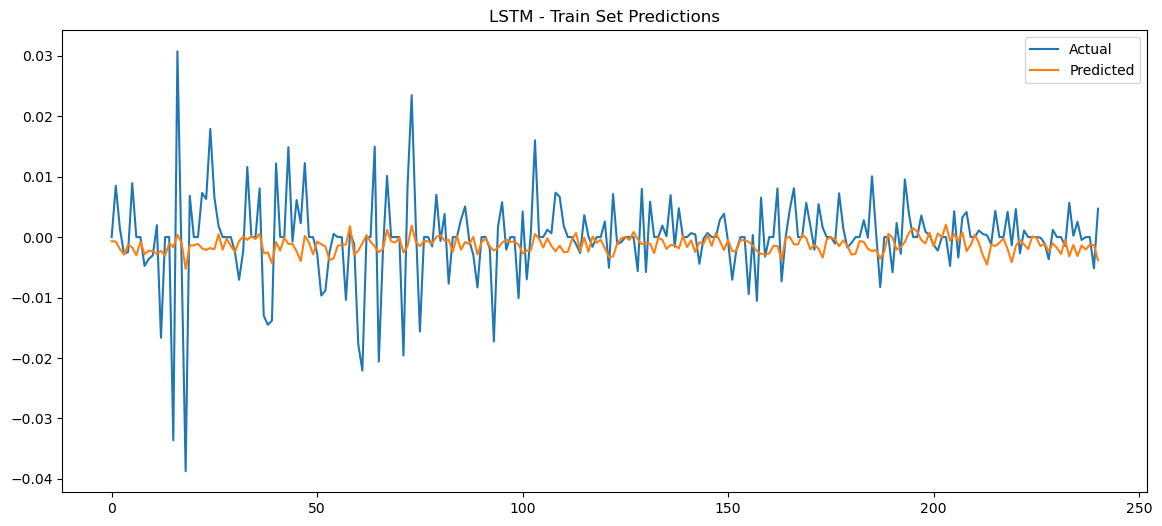

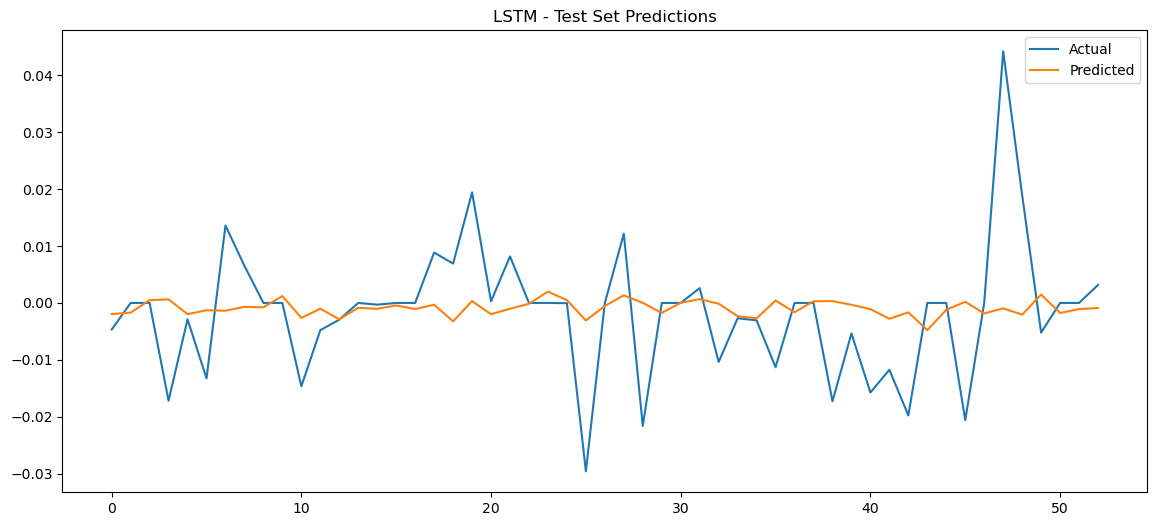

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Transformer Model:
Train RMSE: 0.007060, MAE: 0.004287
Test RMSE: 0.011582, MAE: 0.007367


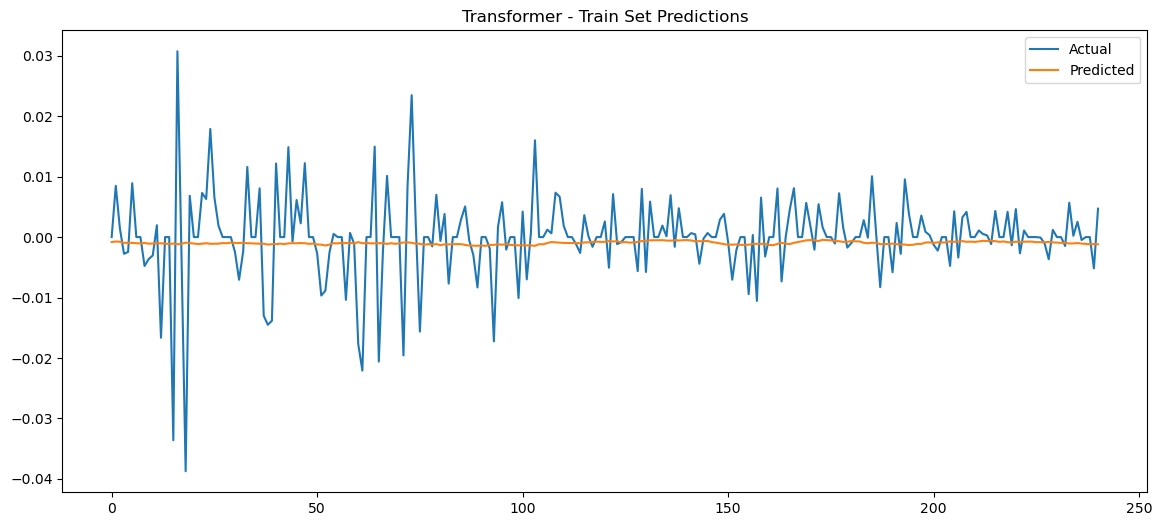

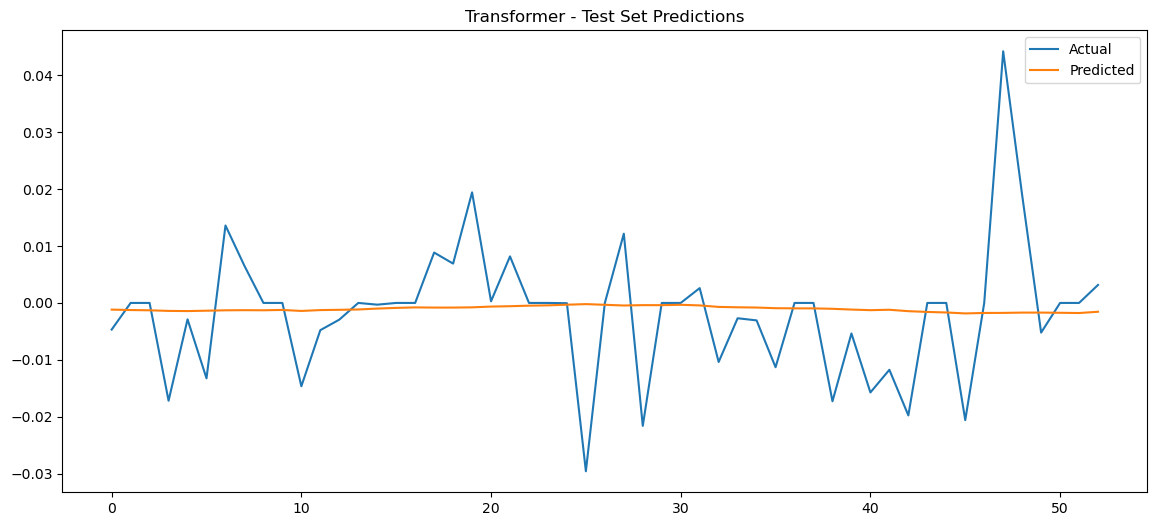

In [11]:
# Evaluate and plot
inverse_transform_and_plot(lstm_model, X_train, y_train, X_test, y_test, 'LSTM')
inverse_transform_and_plot(transformer_model, X_train, y_train, X_test, y_test, 'Transformer')